In [1]:
# Código obtenido del sitio oficial de Keras

import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras

# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

## Idea principal
<img src="Gradcam.jpg"><img>

733657/733657 [==============================] - 0s 1us/step


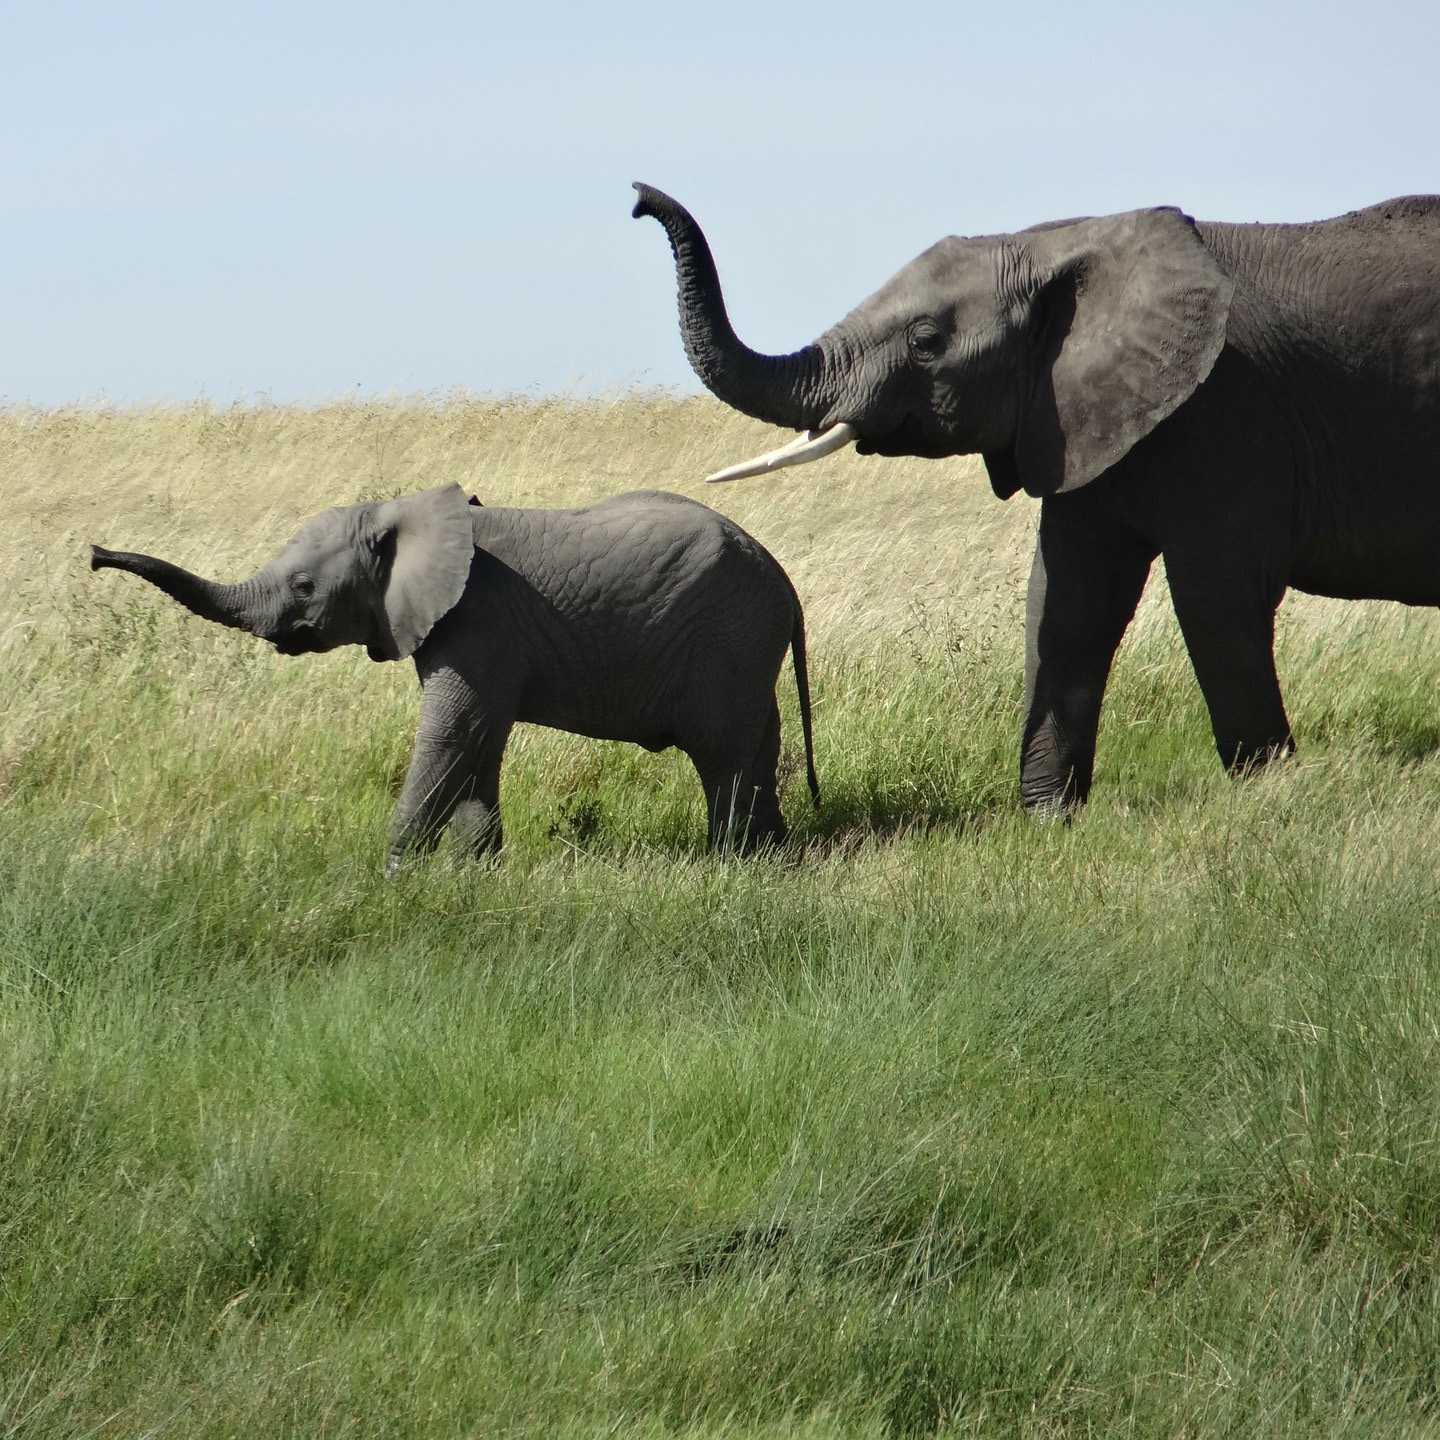

In [3]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
# Realiza algunos ajustes de color que se han realizado a todas las imágenes de entrenamiento de este modelo
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

# Última capa convolucional del modelo Xception
last_conv_layer_name = "block14_sepconv2_act"

# The local path to our target image
img_path = keras.utils.get_file(
    "elephant.jpg",
    "https://img-datasets.s3.amazonaws.com/elephant.jpg",
)

display(Image(img_path))

In [4]:
# Imágen 3D a tensor de imágen 4D
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    # lo siguiente es equivalente a: african_elephant_output = model.output[:,386], 
    # donde elefante es la clase 386 y class_channel es african_elephant_output
    # class_channel contiene el id de la clase pred_index; la 386: elefante, en nuestro ejemplo
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    # Nos devuelve todos los valores de los gradientes que le llegan a cada valor de 
    # activación de cada mapa de activación (canal) en la última capa concvolucional
    # imaginemos 256 mapas de activación de 14x14: obtendremos 14x14x256 valores de gradientes.
    # Estos valores de gradientes indican la importancia de cada area de cada mapa de activacion
    # respecto (gradiente) la salida de la categoria 386 (elefante).
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    # En nuestro ejemplo, el tensor tiene un shape (?,14,14,256)
    # Con la siguiente instrucción promediamos en las dimensiones 0, 1 y 2 (sacamos un valor de cada 
    # 14x14), y nos quedamos con 256 valores promediados, que nos indican lo importante (el peso) que
    # tiene cada mapa de activación (canal) en la clasificación de la imagen de entrada como un elefante.
    # El shape de pooled_grads será (512,) en nuestro ejemplo
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0] # solo hay una imagen [0], no un batch de entrada
    
    # La siguiente instrucción es equivalente a:
    #for i in range(512):
    #    last_conv_layer_output[:,:,i] *= pooled_grads[i]
    # Lo que hacemos es una combinación lineal de los 512 mapas de activación (canales), ponderando cada uno
    # con el peso que obtuvimos promediando sus gradientes individuales.
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    # Elimina dimensiones de tamaño 1 en el tensor (en este caso la primera dimensión (solo un elefante))
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

1/1 [==============================] - 1s 548ms/step
Predicted: [('n02504458', 'African_elephant', 10.399572)]


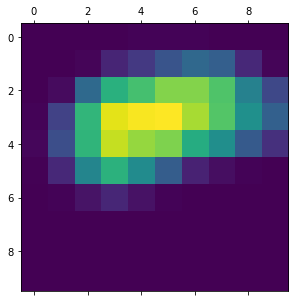

In [5]:
# Aquí preparamos una imagen, le aplicamos GradCam, y visualizamos el heatmap obtenido
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax para dejarla lineal y así obtener valores que representen coloración de pixels
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
# Este método lo proporciona Xception, y nos devuelve información textual acerca de la predicción obtenida
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap; aquí invocamos a nuestro método grad_cam
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

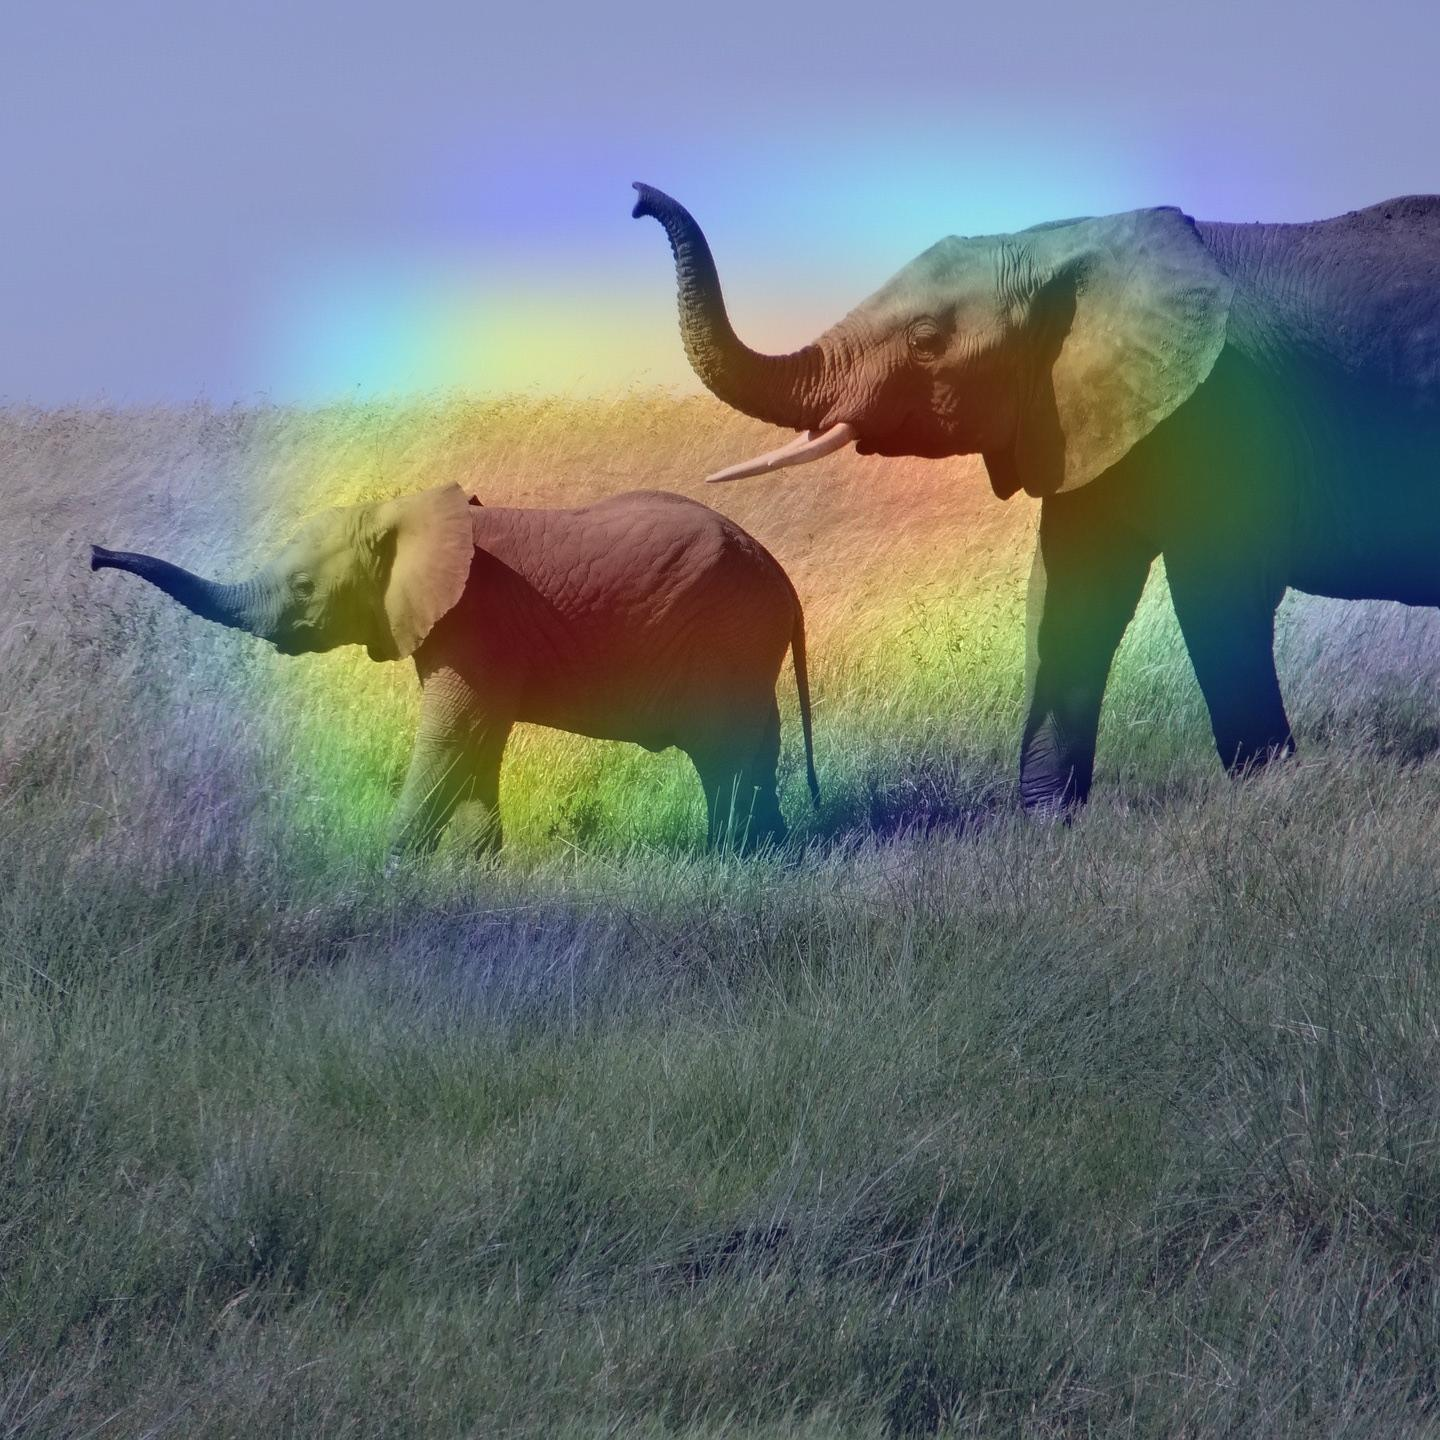

In [6]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255 (para mezclarlo con los pixels de la imagen)
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img  # proporción heatmap vs. imagen en el resultado
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

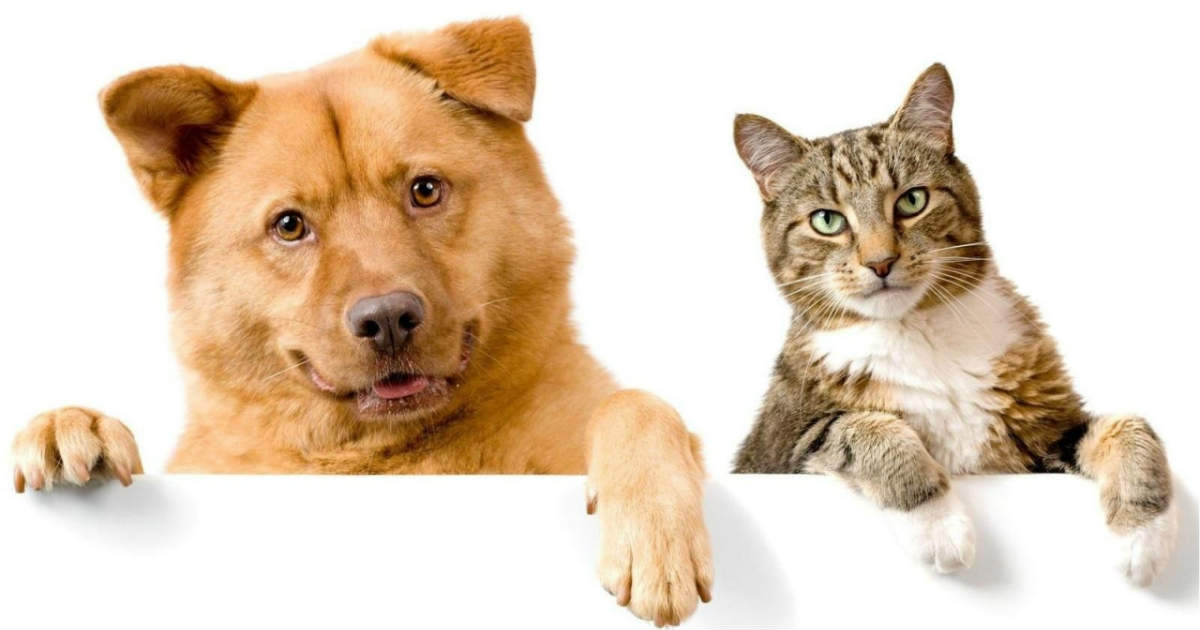

In [10]:
img_path = keras.utils.get_file(
    "cat_and_dog.jpg",
    "https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg",
)

display(Image(img_path))

1/1 [==============================] - 0s 30ms/step
Predicted: [('n02112137', 'chow', 4.611242), ('n02124075', 'Egyptian_cat', 4.381737)]


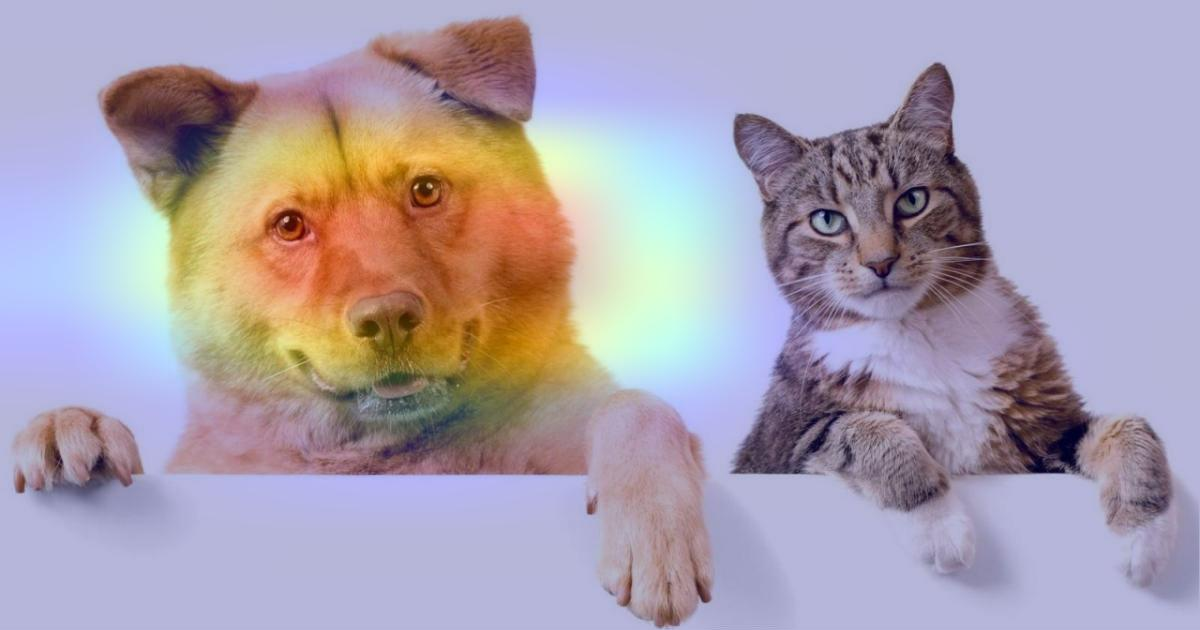

In [11]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Print what the two top predicted classes are
preds = model.predict(img_array)

print("Predicted:", decode_predictions(preds, top=2)[0])
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=260)

save_and_display_gradcam(img_path, heatmap)

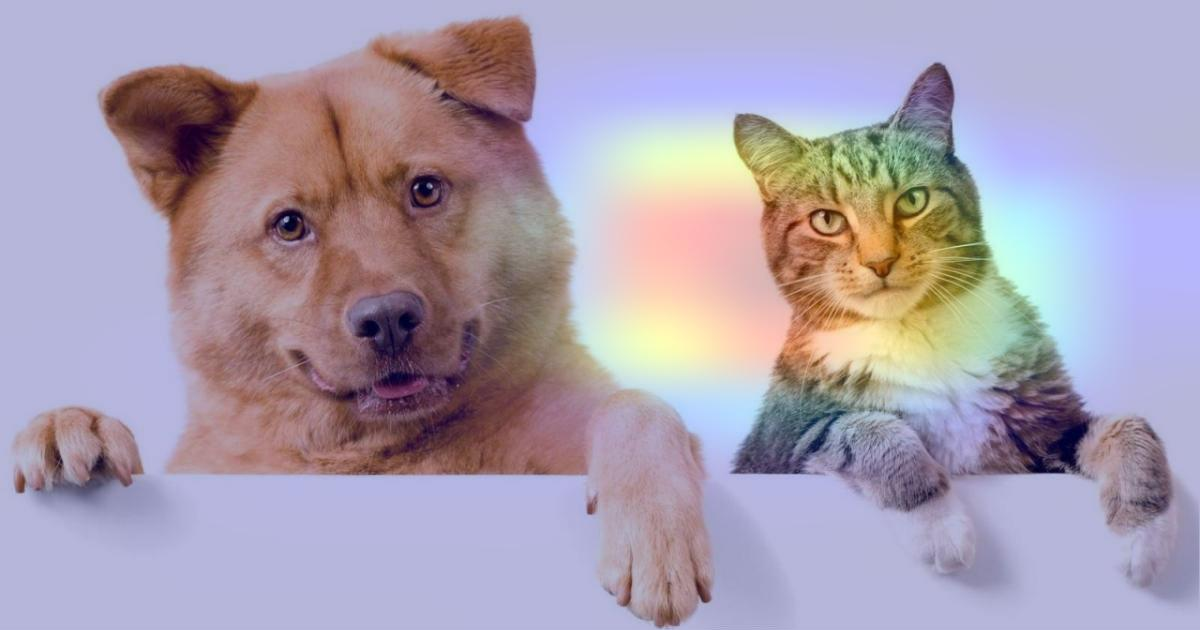

In [9]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=285)

save_and_display_gradcam(img_path, heatmap)